In [1]:
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def polynomialPhase(coeffs:list,t:int)->int:
    """
    Generate the polynomial phase 
    """
    total = 0
    for i in range(1,len(coeffs)+1):
        total += coeffs[i-1]*(t**i/math.factorial(i))
    return total

In [11]:
def chirp(coeffs:list,nS:int,f:int)->list:
    """
    Generate a sample chirp given coeffs, number of samples and frequency 
    """
    outer = []
    for n in range (0,nS-1):
        temp = cmath.exp(2j*math.pi*(polynomialPhase(coeffs,n/f)))
        outer.append(temp)
    return outer

In [39]:
nSamples = 10000
samplingFrequency = 2000
p = chirp([0,1],nSamples,samplingFrequency)

In [40]:
points = [i.real for i in p]

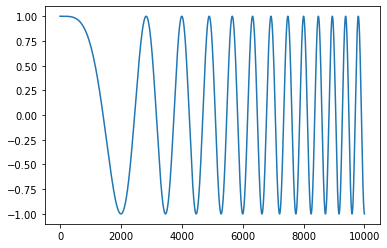

In [41]:
plt.plot(points)

In [29]:
def complexWhiteNoise(nS:int)->list:
    realDist = np.random.normal(0,1/math.sqrt(2),nS-1)
    imgDist = np.random.normal(0,1/math.sqrt(2),nS-1)
    imgDist = [complex(i,1) for i in imgDist]
    return realDist + imgDist

In [83]:
snr = -10
whiteNoisePoints = complexWhiteNoise(nSamples)/(10**(snr/20))
noisyPoints = p + whiteNoisePoints

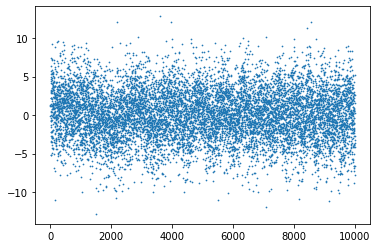

In [84]:
plt.scatter(range(0,len(noisyPoints)),noisyPoints,s=0.5)